In [5]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [6]:
dfac = pd.read_csv('./anx_comments.csv')
dfas = pd.read_csv('./anx_submissions.csv')
dfds = pd.read_csv('./dia_submissions.csv')
dfdc = pd.read_csv('./dia_comments.csv')
dfac = dfac.iloc[:500, :]
dfas = dfas.iloc[:500, :]
dfds = dfds.iloc[:500, :]
dfdc = dfdc.iloc[:500, :]

In [7]:
dfas.shape, dfac.shape, dfds.shape, dfdc.shape

((500, 73), (500, 50), (500, 85), (500, 50))

## Dfas(Anxiety Submissions), dfac(Anxiety Comments)

In [8]:
# Combine title and selftext into a single column
dfas['body'] = dfas['selftext'].astype(str)
dfds['body'] = dfds['selftext'].astype(str)

#Change 'Anxiety' for a binary to be predicted later
dfas['subreddit'] = dfas['subreddit'].replace('Anxiety', 1)
dfas['origin'] = 'submission'
dfac['subreddit'] = dfac['subreddit'].replace('Anxiety', 1)
dfac['origin'] = 'comment'
#Change 'Anxiety' for a binary to be predicted later
dfds['subreddit'] = dfds['subreddit'].replace('diabetes', 0)
dfds['origin'] = 'submission'
dfdc['subreddit'] = dfdc['subreddit'].replace('diabetes', 0)
dfdc['origin'] = 'comment'

In [9]:
# Selecting only the necessary columns
dfas = dfas[['author', 'origin', 'id', 'body',  'score', 'created_utc', 'subreddit']]
dfac = dfac[['author','origin', 'id','body', 'score', 'created_utc', 'subreddit']]
dfds = dfds[['author', 'origin', 'id', 'body',  'score', 'created_utc', 'subreddit']]
dfdc = dfdc[['author','origin', 'id', 'body', 'score', 'created_utc', 'subreddit']]

# Merge it into one dataframe
df_anx = dfas.append(dfac)
df_diab = dfds.append(dfdc)
df = df_anx.append(df_diab, ignore_index=True)

df['body'] = [str(x).replace('\n\n',' ') for x in df["body"]]
df['body'] = [str(x).replace('\n',' ') for x in df["body"]]
df['body'] = [str(x).replace('&amp','') for x in df["body"]]
df['body'] = [str(x).replace(';#x200B;','') for x in df["body"]]
df['body'] = [str(x).replace('*','') for x in df["body"]]
df['body'] = [str(x).lower() for x in df["body"]]

# Making a date column from created utc
df['datetime'] = pd.to_datetime(df['created_utc'], unit = 's').dt.date
df['time'] = pd.to_datetime(df['created_utc'], unit = 's').dt.time

df = df.dropna(how='any')
df = df.drop_duplicates(subset=['body', 'subreddit'])

In [10]:
df['body']

0       tw mention of self harm         my anxiety has...
1       specifically those first few months where the ...
2        i have neighbour. it is not so loud, but time...
3                                               [deleted]
4       anxiety off balance feeling sensitivity to lig...
                              ...                        
1995                                     life water also.
1996    the main thing that bothered me about auto mod...
1997    i don't care if the correction is only 0.7 gim...
1998    welcome to the club diabuddy! i don’t think ty...
1999    welcome newbie. diabetes sucks, but it's not t...
Name: body, Length: 1769, dtype: object

In [11]:
# Extending my list of stop words
#stop_words = stopwords.words("english")
# new_stop_words = ['like', 'just', 'don', 've', 'know', 'time', 'really', 
#                 'want', 'people', 'going', 'think', 'make', 'day', 
#                 'https', 'com', 'much', 'something', 'would', 'go',
#                'even', 'things', 'also', 'got']
# stop_words.extend(new_stop_words)

### Instantiate and create new columns for tokenized words

In [12]:
# sentence tokenizer
df['sent_tokenized'] = df["body"].apply(nltk.sent_tokenize)
# Instantiate tokenizer.
tokenizer = RegexpTokenizer('\s+', gaps=True)
# Run tokenizer.
df['tokens'] = df["body"].apply(tokenizer.tokenize)
# Instantiate lemmatizer. 
lemmatizer = WordNetLemmatizer()
# Lemmatize tokens.
df['tokens_lem'] = [lemmatizer.lemmatize(str(i)) for i in df['tokens']]

## Baseline is 53/46

In [13]:
df['subreddit'].value_counts(normalize = True)

1    0.533635
0    0.466365
Name: subreddit, dtype: float64

## Pre-Processing
Let's review some of the pre-processing steps for text data:

* Remove special characters
* Tokenizing
* Lemmatizing/Stemming
* Stop word removal

In [14]:
X = df['tokens_lem']
y = df['subreddit']

In [15]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

In [16]:
# Extending my list of stop words
stop_words = stopwords.words("english")
print(f'Length of Old Stop Words: {len(stop_words)}')
new_stop_words = ['like', 'just', 'don', 've', 'know', 'time', 'really', 
                'want', 'people', 'going', 'think', 'make', 'day', 
                'https', 'com', 'much', 'something', 'would', 'go',
               'even', 'things', 'also', 'got']
stop_words.extend(new_stop_words)
print(f'Length of New Stop Words: {len(stop_words)}')

Length of Old Stop Words: 179
Length of New Stop Words: 202


## KNeighbors

In [17]:
# Instantiate the transformer.
tvec = TfidfVectorizer()
knn = KNeighborsClassifier()

In [18]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words= stop_words)),
    ('knn', KNeighborsClassifier())
])

In [19]:
# eucledian is default

In [24]:
pipe_params = {
    'tvec__max_features': [2000, 3000, 5000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)],
    'knn__n_neighbors':[7, 9]
}

In [25]:
# Instantiate GridSearchCV.
gs_tvec = GridSearchCV(
    pipe_tvec,
    param_grid = pipe_params,
    cv = 5,
    n_jobs = -1,
    verbose=1
)

In [26]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
  

In [30]:
# Best parameters
gs_tvec.best_params_

{'knn__n_neighbors': 9,
 'tvec__max_features': 5000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None}

In [31]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.8042194092827004

In [32]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.708904109589041

In [33]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate the specificity and precision
spec = tn / (tn + fp)
prec = tp / (tp + fp)

print('specificity:', spec)
print('precision:', prec)

specificity: 0.4411764705882353
precision: 0.6591928251121076


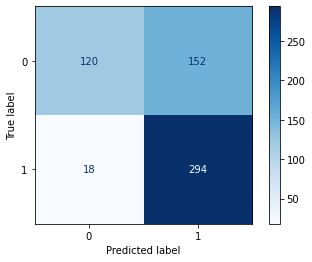

In [34]:
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues');

### Make changes on hyperparameters

In [36]:
pipe_params = {
    'tvec__max_features': [5000, 6000, 7000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)],
    'knn__n_neighbors':[10, 13]
}

In [37]:
# Instantiate GridSearchCV.
gs_tvec = GridSearchCV(
    pipe_tvec,
    param_grid = pipe_params,
    cv = 5,
    n_jobs = -1,
    verbose=1
)

In [38]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
  

In [39]:
# Best parameters
gs_tvec.best_params_

{'knn__n_neighbors': 13,
 'tvec__max_features': 7000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [40]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.8725738396624473

In [41]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.7551369863013698

In [42]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate the specificity and precision
spec = tn / (tn + fp)
prec = tp / (tp + fp)

print('specificity:', spec)
print('precision:', prec)

specificity: 0.5477941176470589
precision: 0.7036144578313253


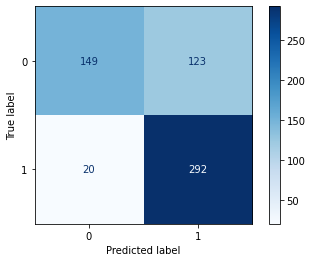

In [43]:
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues');